In [1]:
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
import gsw
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter as gf
import numpy as np

June 06-08

In [2]:
ds_day1 = xr.open_dataset('LLC4320_pre-SWOT_NWPacific_20120606.nc')
ds_day2 = xr.open_dataset('LLC4320_pre-SWOT_NWPacific_20120607.nc')
ds_day3 = xr.open_dataset('LLC4320_pre-SWOT_NWPacific_20120608.nc')

In [3]:
ds_concat = xr.concat([ds_day1, ds_day2, ds_day3], dim='time')

In [4]:
time_window = 24 # in hours
time_selected = 25
lat_selected = 100
ds_avg = ds_concat.rolling(time=time_window).mean() # running mean
#ds = ds.isel(time=time_selected)

In [5]:
ds = ds_avg.isel(time = time_selected)

In [6]:
ds = ds.assign_coords(Z=('k',ds.Z))
ds = ds.assign_coords(X=(('j_g','i_g'), ds.XG))
ds = ds.assign_coords(XC=(('j','i'), ds.XC))
ds = ds.assign_coords(YC=(('j','i'), ds.YC))

In [7]:
ds['p'] = ('k', gsw.p_from_z(ds.Z,ds.YC.mean()))
p,XC,YC = xr.broadcast(ds.p,ds.XC,ds.YC)
ds['SA'] = (('k','j','i'), gsw.SA_from_SP(ds.Salt,p,XC,YC))
ds['CT'] = (('k','j','i'), gsw.CT_from_t(ds.SA,ds.Theta,p))
#dss['geo_strf_height'] = (('k','j','i'), gsw.geo_strf_dyn_height(dss.Salt, dss.Theta, -dss.Z))
p_ref = 500
ds['geo_height'] = (('k','j','i'),gsw.geo_strf_dyn_height(ds.SA,ds.CT,-ds.Z,p_ref))

In [8]:
[geostrophic_velocity, mid_lat, mid_long] = gsw.geostrophic_velocity(ds.geo_height.isel(j = 100),
                                                                     ds.XC.isel(j = 100),ds.YC.isel(j = 100))


In [9]:
geo_U, midlon1, midlat1 = gsw.geostrophic_velocity(
    ds.geo_height.isel(i = 100),
    ds.XC.isel(i = 100),
    ds.YC.isel(i= 100))

In [10]:
zero = np.zeros(89)
hzero = zero.reshape(89,1)
geo_v_whole = np.append(geostrophic_velocity,hzero,axis = 1)

In [11]:
ds['geo_V'] = (('k','i'),geo_v_whole)
geo_u_whole = np.append(geo_U,hzero,axis = 1)
ds['geo_U'] = (('k','j'),geo_u_whole)

In [12]:
grid = xgcm.Grid(ds, coords={"X": {"center": "i", "left": "i_g"}, 
 "Y": {"center": "j", "left": "j_g"},
 "Z": {"center": "k"},
 "T": {"center": "time"},}, metrics = {('X',):['DXC', 'DXG'],
                                       ('Y',):['DYC', 'DYG'],
                                       ('X','Y'): ['RAZ']})

grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
Z Axis (periodic, boundary=None):
  * center   k
T Axis (periodic, boundary=None):
  * center   time

In [13]:
ds['zeta'] = (-grid.diff(ds.U * ds.DXC, 'Y', boundary='extend') +
                    grid.diff(ds.V * ds.DYC, 'X', boundary='extend'))/ds.RAZ

In [14]:
ds['gf_Geo_V'] = (('k', 'i'), gf(ds.geo_V, sigma = 10, mode='nearest',cval=0)) 
ds['gf_Geo_U'] = (('k', 'j'), gf(ds.geo_U, sigma = 10, mode='nearest',cval=0))

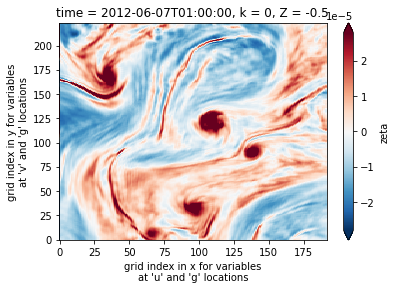

In [62]:
ds.zeta.isel(k=0).plot(robust = True)


In [17]:
ds['K_energy'] = grid.interp(ds.U**2, ['X','Y'], boundary = 'extend') + (ds.V)**2

In [18]:
ds['density'] = (('k','j','i'),gsw.rho(ds.SA, ds.CT, p)-1000)

In [19]:
ds['f'] = (('j'),gsw.f(ds.YC.mean(dim = 'i'))) #Coriolis force

In [20]:
ds['shear_sq'] = grid.interp(ds.U.differentiate('Z')**2, ['X','Y'], boundary = 'extend') + ds.V.differentiate('Z')**2

In [21]:
N2, kmid = gsw.Nsquared(ds.SA,ds.CT, p)
ad = N2[87] - N2[86] + N2[87]
new  = np.append(N2, np.atleast_3d(ad)).reshape(89,224,192)

In [22]:
ds['stratification'] = (('k','j','i'),new) 

In [23]:
ds['Wx'] = -ds.V.differentiate('Z')
ds['Wy'] = -ds.U.differentiate('Z')
ds['grad_rho_x'] = grid.derivative(ds.density, 'X', boundary='extend')
ds['grad_rho_y'] = grid.derivative(ds.density, 'Y', boundary='extend')
ds['grad_rho_z'] = ds.density.differentiate('Z')

In [24]:
ds['Q'] = -(grid.interp(ds.Wx, ['Y'], boundary = 'extend') * grid.interp(ds.grad_rho_x, ['X'], boundary = 'extend')  #j, i
      + grid.interp(ds.Wy,['X'], boundary = 'extend') * grid.interp(ds.grad_rho_y, ['Y'], boundary = 'extend')   #j ,i
      + (grid.interp(ds.zeta, ['X','Y'], boundary = 'extend') + ds.f)*ds.grad_rho_z # j, i 
     )/ds.density # j, i

In [25]:
ds['Q_1'] = -(grid.interp(ds.Wx, ['Y'], boundary = 'extend') * grid.interp(ds.grad_rho_x, ['X'], boundary = 'extend')  #j, i
      + grid.interp(ds.Wy,['X'], boundary = 'extend') * grid.interp(ds.grad_rho_y, ['Y'], boundary = 'extend')   #j ,i
      + (grid.interp(ds.zeta, ['X','Y'], boundary = 'extend') + ds.f)*ds.grad_rho_z # j, i 
     )/ds.density.mean() # j, i

In [26]:
ds['turbulence'] = ds.stratification/ grid.interp(ds.shear_sq, ['Y'], boundary = 'extend')

In [27]:
ds['log_PV'] = np.log10(-ds.Q)
ds['log_tur'] = np.log10(ds.turbulence)
ds['log_shear'] = np.log10(ds.shear_sq)
ds['log_shear_i'] = ds.log_shear.isel(i= 100).values.flatten()
ds['log_stra'] = np.log10(ds.stratification)

/Users/Daniel/opt/anaconda3/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


In [94]:
ds['distance_one'] = gsw.distance(ds.XC.isel(i = 110),ds.YC.isel(i = 110))

In [101]:
ds['distance_one_j'] = gsw.distance(ds.XC.isel(j = 125),ds.YC.isel(j = 125))

In [140]:
ds['distance_XG'] = gsw.distance(ds.XG.isel(i_g = 110),ds.YG.isel(i_g = 110))
ds['distance_YG'] = gsw.distance(ds.XG.isel(j_g = 125),ds.YG.isel(j_g = 125))

In [144]:
distance = ds.distance_YG.values
distance = np.insert(distance,0,0)
for i in range(1,len(distance)):
    distance[i] = distance[i-1] + distance[i]
distance = distance/1000

In [143]:
ds = ds.assign_coords(DYG = (('j_g'),distance))

In [145]:
ds = ds.assign_coords(DXG = (('i_g'),distance))

In [103]:
ds = ds.assign_coords(XDI = (('i'), distance))

In [98]:
ds = ds.assign_coords(XD=(('j'), distance))

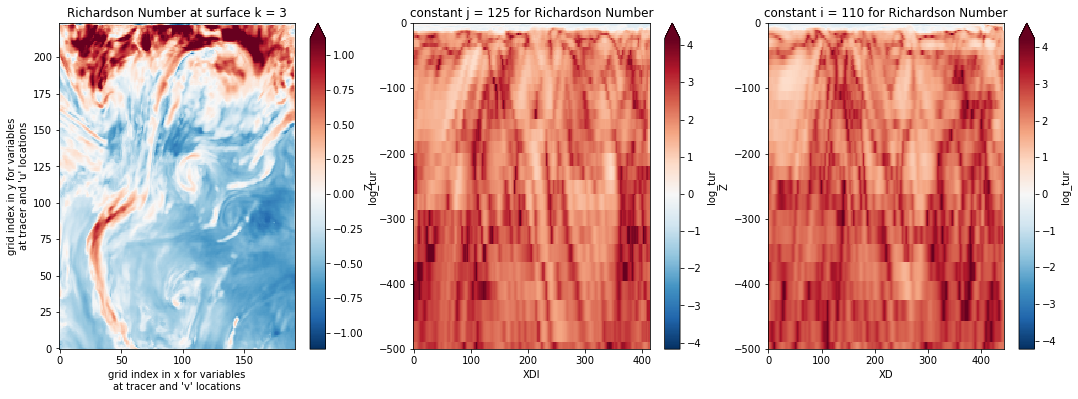

In [202]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
ds.log_tur.isel(k=3).plot(robust=True, ax = ax[0])
ds.log_tur.isel(i = 110).plot(robust = True,y  = 'Z',x = 'XD',ax = ax[2])
ds.log_tur.isel(j = 125).plot(robust=True, y = 'Z',x='XDI',ax = ax[1])
ax[2].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[2].set_title('constant i = 110 for Richardson Number')
ax[1].set_title('constant j = 125 for Richardson Number')
ax[0].set_title('Richardson Number at surface k = 3')
plt.savefig('Richardson Number')

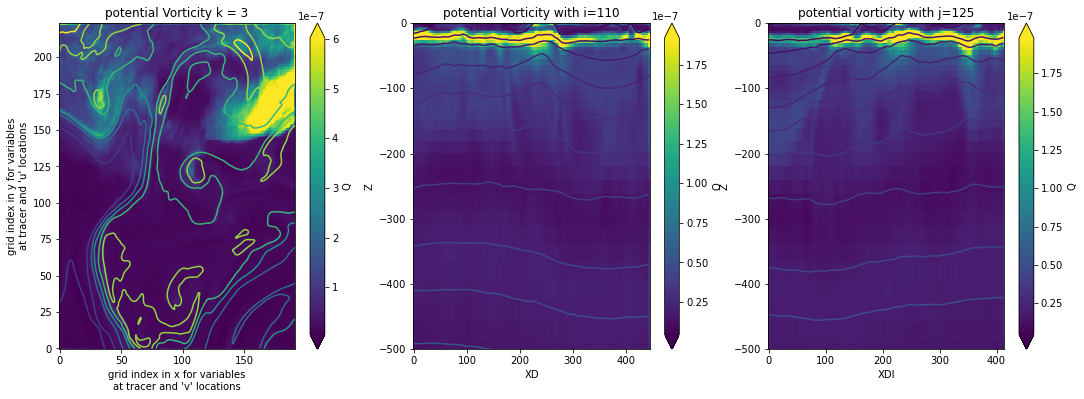

In [112]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
ds.density.isel(k=3).plot.contour(robust = True, ax = ax[0])
ds.Q.isel(k=0).plot(robust = True, ax = ax[0])
ds.density.isel(i=110).plot.contour(robust = True,y='Z',x = 'XD' ,ax = ax[1], levels = 50)
ds.Q.isel(i=110).plot(robust = True,y='Z', x = 'XD', ax = ax[1])
ds.Q.isel(j = 125).plot(robust = True, y = 'Z', x = 'XDI', ax = ax[2])
ds.density.isel(j=125).plot.contour(robust = True,y='Z',x = 'XDI' ,ax = ax[2], levels = 50)
ax[1].set_ylim(-500,0)
ax[2].set_ylim(-500,0)
ax[0].set_title('potential Vorticity k = 3')
ax[1].set_title('potential Vorticity with i=110')
ax[2].set_title('potential vorticity with j=125')
plt.savefig('PV with 3 Panels')

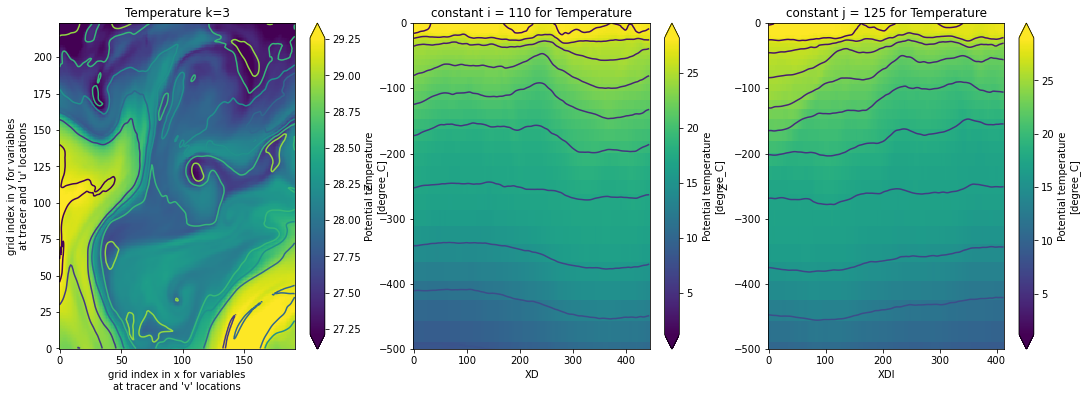

In [195]:
fig, ax = plt.subplots(1,3, figsize = (18,6))

ds.Theta.isel(k = 3).plot(robust = True, ax = ax[0])
ds.Theta.isel(j = 125).plot(robust = True,y  = 'Z',x ='XDI' ,ax = ax[2])
ds.Theta.isel(i = 110).plot(robust=True, y = 'Z',x = 'XD' ,ax = ax[1])
ds.density.isel(k=0).plot.contour(robust = True, ax = ax[0])
ds.density.isel(j=125).plot.contour(robust = True, ax = ax[2])
ds.density.isel(j=125).plot.contour(robust = True,y='Z',x = 'XDI' ,ax = ax[2], levels = 50)
ds.density.isel(i=110).plot.contour(robust = True,y='Z',x = 'XD' ,ax = ax[1], levels = 50)
ax[2].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[2].set_title('constant j = 125 for Temperature')
ax[1].set_title('constant i = 110 for Temperature')
ax[0].set_title('Temperature k=3')
plt.savefig('Temperature')

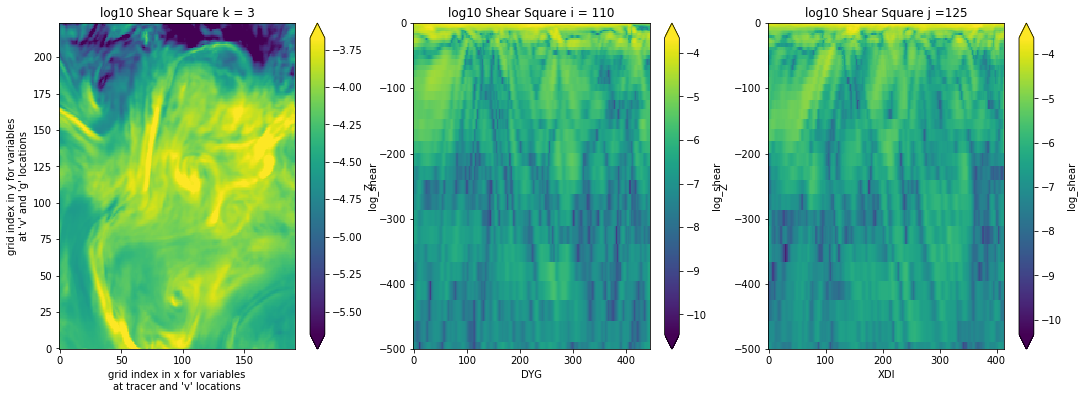

In [200]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

ds.log_shear.isel(k=3).plot(robust = True, ax = ax[0])
ds.log_shear.isel(i = 110).plot(robust = True, y = 'Z', x = 'DYG',ax = ax[1])
ds.log_shear.isel(j_g = 125).plot(robust = True, y = 'Z', x = 'XDI',ax = ax[2])
ax[2].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('log10 Shear Square k = 3')
ax[1].set_title('log10 Shear Square i = 110')
ax[2].set_title('log10 Shear Square j =125')
plt.savefig('log10 Shear Square')

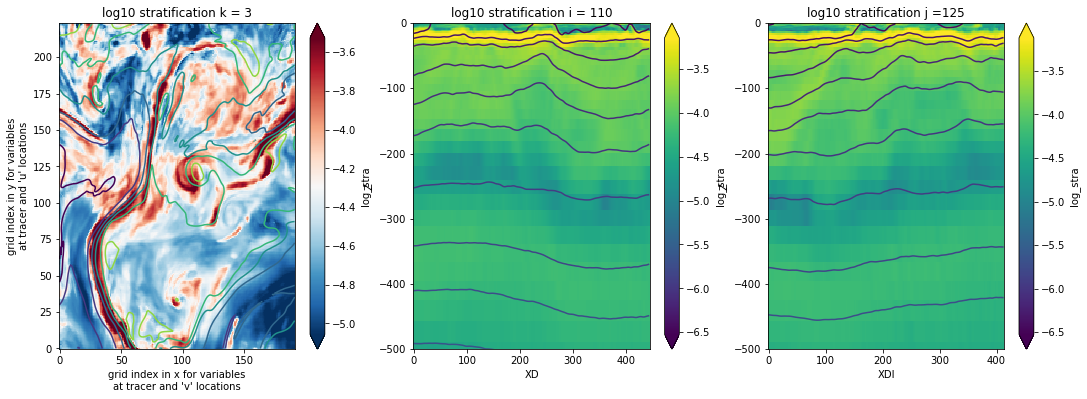

In [159]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

ds.log_stra.isel(k=3).plot(robust = True, cmap = 'RdBu_r', ax = ax[0])
ds.density.isel(k=0).plot.contour(robust = True, ax = ax[0])
ds.log_stra.isel(i = 110).plot(robust = True, y = 'Z', x = 'XD',ax = ax[1])
ds.density.isel(i=110).plot.contour(robust = True,y='Z',x = 'XD' ,ax = ax[1], levels = 50)
ds.log_stra.isel(j = 125).plot(robust = True, y = 'Z', x = 'XDI',ax = ax[2])
ds.density.isel(j=125).plot.contour(robust = True,y = 'Z', x = 'XDI',ax = ax[2], levels = 50)
ax[2].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('log10 stratification k = 3')
ax[1].set_title('log10 stratification i = 110')
ax[2].set_title('log10 stratification j =125')
plt.savefig('log10 stratification')

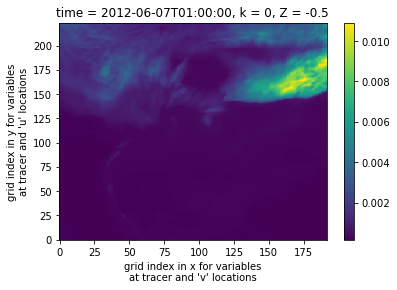

In [38]:
(-ds.grad_rho_z.isel(k=0) * (1/ds.density.mean())).plot()

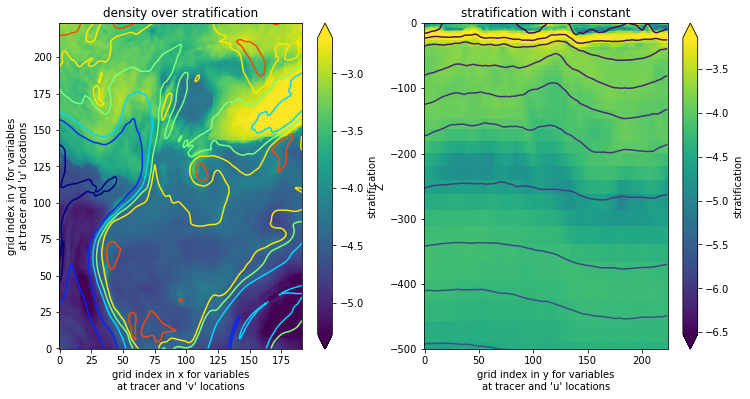

In [66]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ds.density.isel(k=0).plot.contour(robust = True, ax = ax[0], cmap = 'jet')
(ds.stratification.isel(k=0)).pipe(np.log10).plot(robust = True, ax = ax[0], cmap = 'viridis')
ds.density.isel(i=110).plot.contour(robust = True,y='Z', ax = ax[1], levels = 50)
ds.stratification.isel(i=110).pipe(np.log10).plot(robust = True,y='Z', ax = ax[1])
ax[1].set_ylim(-500,0)
ax[0].set_title('density over stratification')
ax[1].set_title('stratification with i constant') 


Text(0.5, 1.0, 'stratification with i constant')

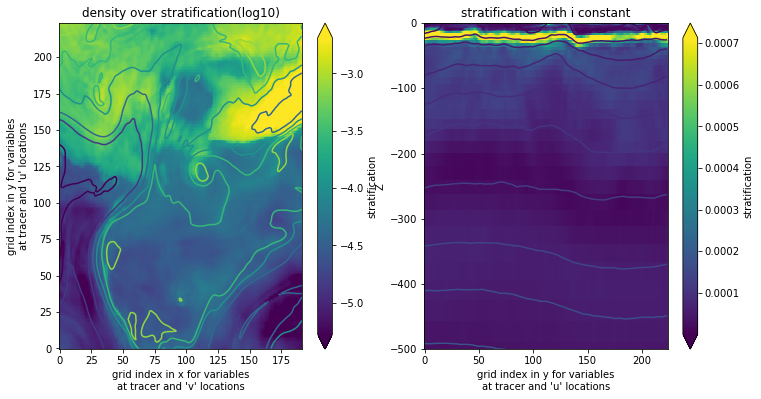

In [47]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ds.density.isel(k=0).plot.contour(robust = True, ax = ax[0])
ds.stratification.isel(k=0).pipe(np.log10).plot(robust = True, ax = ax[0])
ds.density.isel(i=110).plot.contour(robust = True,y='Z', ax = ax[1], levels = 50)
ds.stratification.isel(i=110).plot(robust = True,y='Z', ax = ax[1])
ax[1].set_ylim(-500,0)
ax[0].set_title('density over stratification(log10)')
ax[1].set_title('stratification with i constant') 

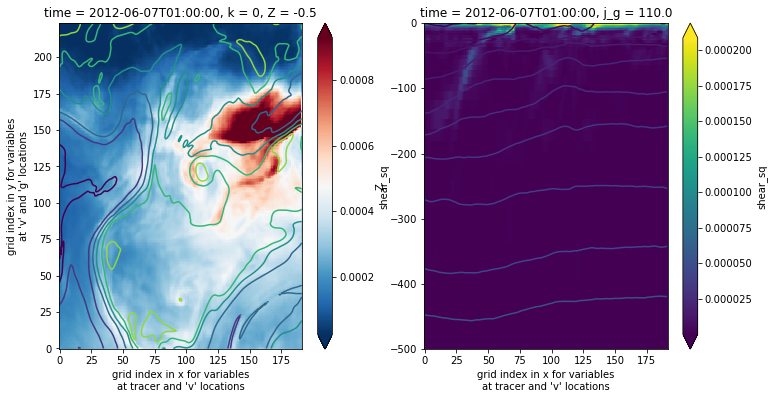

In [67]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ds.density.isel(k=0).plot.contour(robust = True, ax = ax[0])
ds.shear_sq.isel(k=0).plot(robust = True,cmap = 'RdBu_r' ,ax = ax[0])
ds.density.isel(j=110).plot.contour(robust = True,y='Z', ax = ax[1], levels = 50)
ds.shear_sq.isel(j_g=110).plot(robust = FTrue,y='Z', ax = ax[1])
ax[1].set_ylim(-500,0)


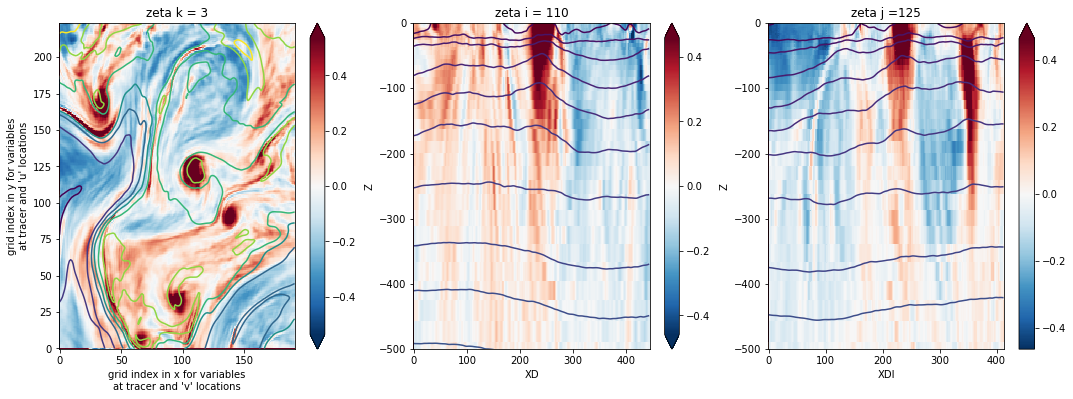

In [187]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

(ds.zeta.isel(k=3)/ds.f.mean()).plot(robust = True, cmap = 'RdBu_r', ax = ax[0])
ds.density.isel(k=3).plot.contour(robust = True, ax = ax[0])
(ds.zeta.isel(i_g = 110)/ds.f.mean()).plot(robust = True, y = 'Z', x = 'DYG',ax = ax[1])
ds.density.isel(i=110).plot.contour(robust = True,y='Z',x = 'XD' ,ax = ax[1], levels = 50)
(ds.zeta.isel(j_g = 125)/ds.f.mean()).plot(robust = True, y = 'Z', x = 'DXG',ax = ax[2])
ds.density.isel(j=125).plot.contour(robust = True,y = 'Z', x = 'XDI',ax = ax[2], levels = 50)
ax[2].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('zeta k = 3')
ax[1].set_title('zeta i = 110')
ax[2].set_title('zeta j =125')
plt.savefig('Vorticity 3 panels')

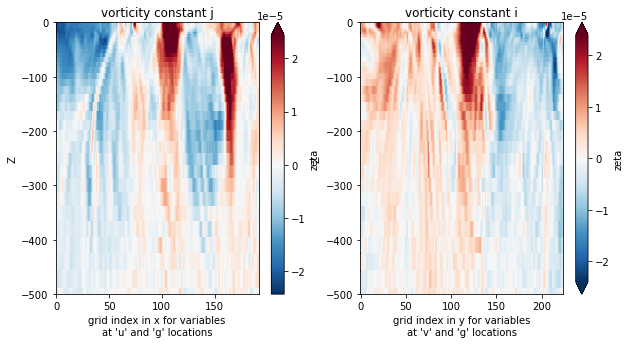

In [68]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ds.zeta.isel(j_g = 125).plot(robust = True,y  = 'Z', ax = ax[0])
ds.zeta.isel(i_g = 110).plot(robust=True, y = 'Z', ax = ax[1])
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('vorticity constant j')
ax[1].set_title('vorticity constant i')


In [54]:
gap = midlat1[1]-midlat1[0]
gap1 = mid_lat[1] - mid_lat[0]
add = midlat1[222] + gap
add1 = mid_lat[190] + gap1
midlat1 = np.append(midlat1,add)
mid_lat = np.append(mid_lat,add1)

Text(0.5, 1.0, 'Geostrophic_U')

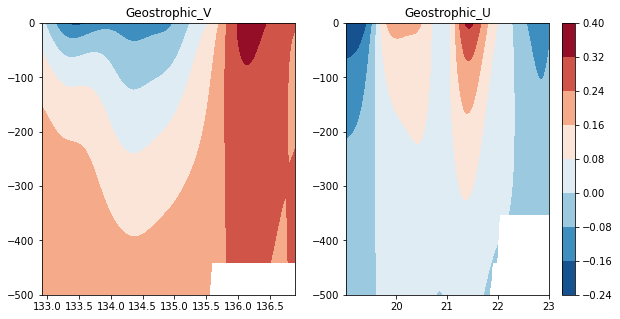

In [73]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].contourf(mid_lat,ds.Z,ds.gf_Geo_V, cmap='RdBu_r')
h = ax[1].contourf(midlat1,ds.Z,ds.gf_Geo_U, cmap='RdBu_r')
plt.colorbar(h)
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('Geostrophic_V')
ax[1].set_title('Geostrophic_U')

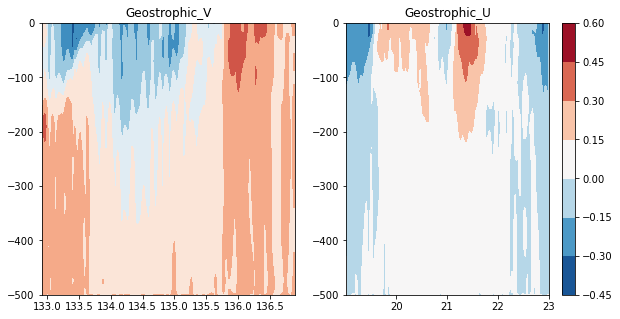

In [69]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].contourf(mid_lat,ds.Z,ds.geo_V, cmap='RdBu_r')
h = ax[1].contourf(midlat1,ds.Z,ds.geo_U, cmap='RdBu_r')
plt.colorbar(h)
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('Geostrophic_V')
ax[1].set_title('Geostrophic_U')
plt.savefig('Geostrophic U and G')

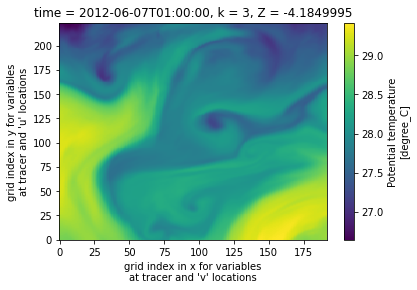

In [77]:
ds.Theta.isel(k=3).plot()

In [163]:
ds.U

<xarray.DataArray 'U' (k: 89, j: 224, i_g: 192)>
array([[[-1.36811778e-01, -1.28449559e-01, -1.17420122e-01, ...,
          6.84681833e-02,  6.23033941e-02,  5.66195175e-02],
        [-1.37293056e-01, -1.28513202e-01, -1.16818115e-01, ...,
          6.74515590e-02,  6.17736094e-02,  5.88650480e-02],
        [-1.37399793e-01, -1.29432201e-01, -1.18019342e-01, ...,
          7.01105967e-02,  6.53459206e-02,  6.43859133e-02],
        ...,
        [ 1.56907335e-01,  1.60901338e-01,  1.71276927e-01, ...,
          1.52187929e-01,  1.53993070e-01,  1.50644690e-01],
        [ 1.62504792e-01,  1.69575453e-01,  1.80129111e-01, ...,
          1.61068678e-01,  1.64064676e-01,  1.60956755e-01],
        [ 1.68519065e-01,  1.79521978e-01,  1.89601168e-01, ...,
          1.69879779e-01,  1.72341794e-01,  1.71141356e-01]],

       [[-1.35567814e-01, -1.27240628e-01, -1.16204999e-01, ...,
          6.67850673e-02,  6.05512336e-02,  5.47899678e-02],
        [-1.36080906e-01, -1.27359301e-01, -1.15640059e-01, ...,
          6.56355172e-02,  5.98757043e-02,  5.68995588e-02],
        [-1.36272460e-01, -1.28271371e-01, -1.16866283e-01, ...,
          6.81676418e-02,  6.33124635e-02,  6.22810982e-02],
...
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * j        (j) float32 0.0 1.0 2.0 3.0 4.0 ... 219.0 220.0 221.0 222.0 223.0
    time     datetime64[ns] 2012-06-07T01:00:00
  * i_g      (i_g) float32 0.0 1.0 2.0 3.0 4.0 ... 187.0 188.0 189.0 190.0 191.0
    DXG      (i_g) float64 0.0 2.163 4.32 6.477 ... 405.9 408.1 410.2 412.4
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 79 80 81 82 83 84 85 86 87 88
    Z        (k) float32 -0.5 -1.57 -2.79 ... -5.499e+03 -5.882e+03 -6.301e+03
    XD       (j) float64 0.0 2.015 4.028 6.043 8.056 ... 437.4 439.4 441.3 443.3
Attributes:
    long_name:              Horizontal velocity in the model +x direction
    units:                  m s-1
    standard_name:          sea_water_x_velocity
    comments_1:             Horizontal velocity in the +x direction at the 'u...
    comments_2:             Note: in the Arakawa-C grid, horizontal velocitie...
    direction:              >0 increases volume
    internal note:          INCLUDE HFACW FOR VOLUME MEAN CALCULATIONS
    grid_location:          u
    coverage_content_type:  modelResult
    valid_min:              -2.0
    valid_max:              2.0

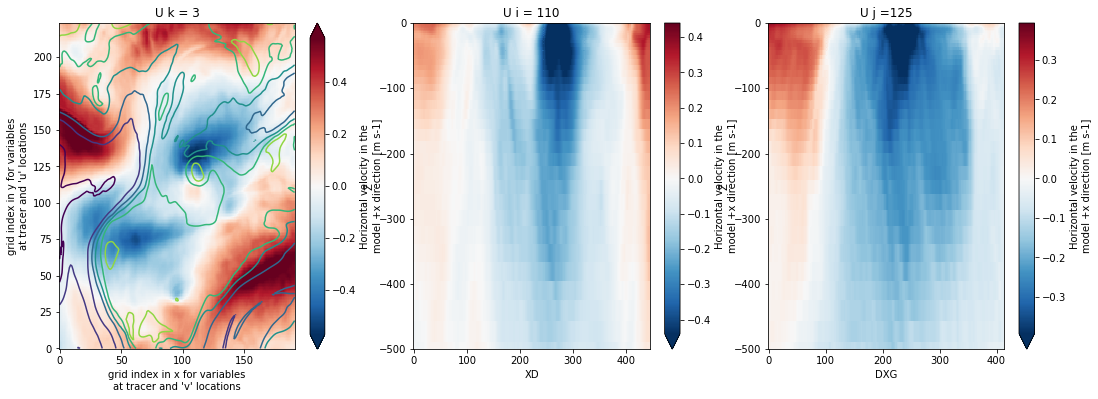

In [169]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

ds.U.isel(k=3).plot(robust = True, cmap = 'RdBu_r', ax = ax[0])
ds.density.isel(k=0).plot.contour(robust = True, ax = ax[0])
ds.U.isel(i_g = 110).plot(robust = True, y = 'Z', x = 'XD',ax = ax[1])
ds.U.isel(j = 125).plot(robust = True, y = 'Z', x = 'DXG',ax = ax[2])
ax[2].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('U k = 3')
ax[1].set_title('U i = 110')
ax[2].set_title('U j =125')
plt.savefig('normal U')

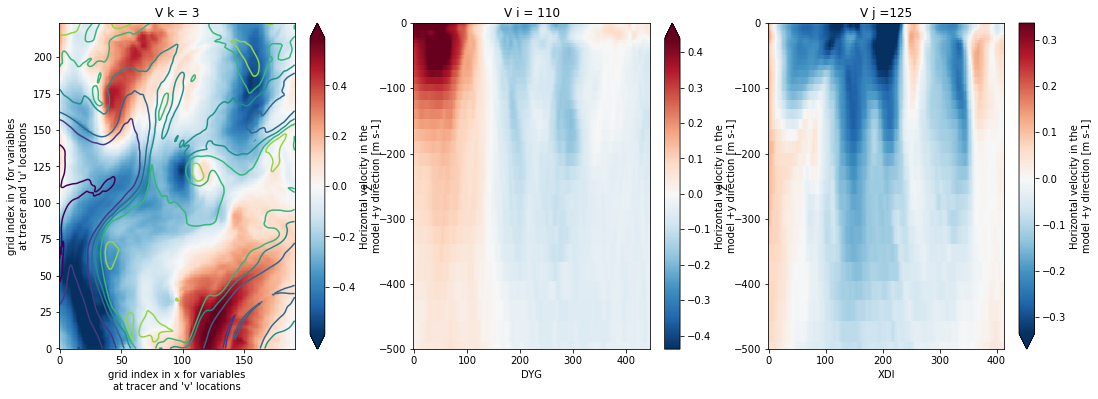

In [170]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

ds.V.isel(k=3).plot(robust = True, cmap = 'RdBu_r', ax = ax[0])
ds.density.isel(k=0).plot.contour(robust = True, ax = ax[0])
ds.V.isel(i = 110).plot(robust = True, y = 'Z', x = 'DYG',ax = ax[1])
ds.V.isel(j_g = 125).plot(robust = True, y = 'Z', x = 'XDI',ax = ax[2])
ax[2].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('V k = 3')
ax[1].set_title('V i = 110')
ax[2].set_title('V j =125')
plt.savefig('normal V')

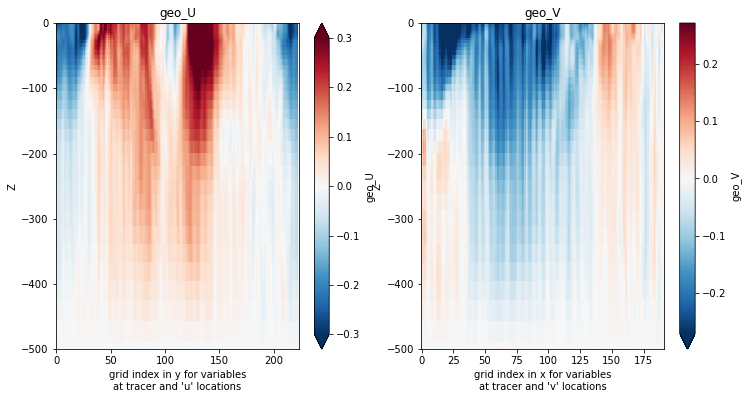

In [175]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ds.geo_U.plot(robust = True, y = 'Z',cmap = 'RdBu_r', ax = ax[0])
ds.geo_V.plot(robust = True, y = 'Z',cmap = 'RdBu_r',ax = ax[1])
ax[1].set_ylim(-500,0)
ax[0].set_ylim(-500,0)
ax[0].set_title('geo_U')
ax[1].set_title('geo_V')

plt.savefig('geostrophic U and geostrophic V')

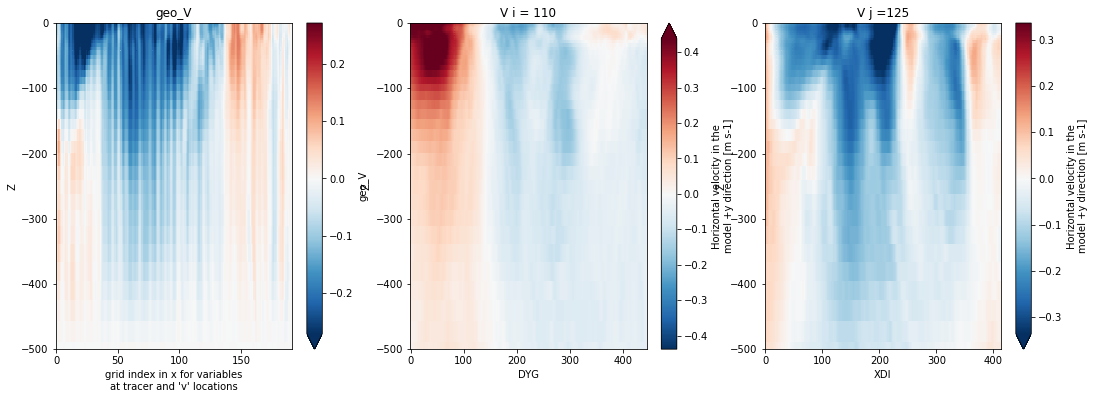

In [179]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

ds.geo_V.plot(robust = True,y = 'Z', cmap = 'RdBu_r', ax = ax[0])
ds.V.isel(i = 110).plot(robust = True, y = 'Z', x = 'DYG',ax = ax[1])
ds.V.isel(j_g = 125).plot(robust = True, y = 'Z', x = 'XDI',ax = ax[2])
ax[2].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_ylim(-500,0)
ax[0].set_title('geo_V')
ax[1].set_title('V i = 110')
ax[2].set_title('V j =125')
plt.savefig('normal V and geo V')

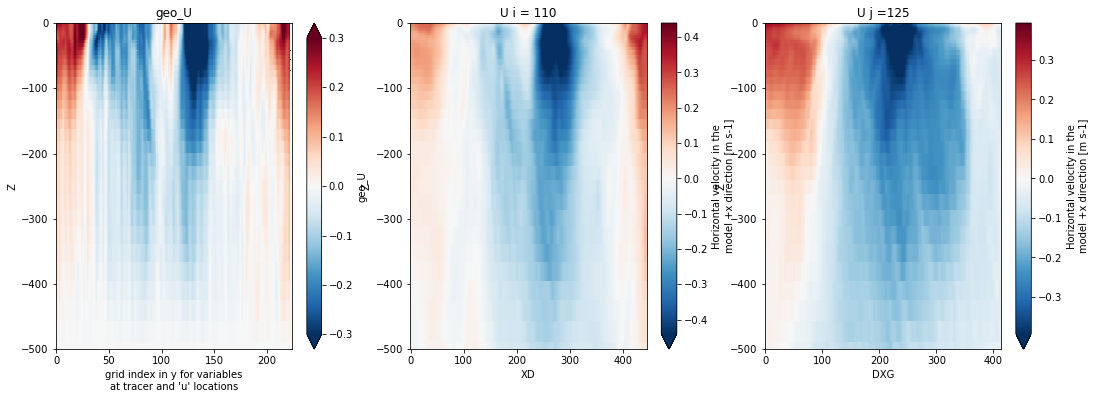

In [185]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

(-ds.geo_U).plot(robust = True,y = 'Z', cmap = 'RdBu_r', ax = ax[0])
ds.U.isel(i_g = 110).plot(robust = True, y = 'Z', x = 'XD',ax = ax[1])
ds.U.isel(j = 125).plot(robust = True, y = 'Z', x = 'DXG',ax = ax[2])
ax[2].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_ylim(-500,0)
ax[0].set_title('geo_U')
ax[1].set_title('U i = 110')
ax[2].set_title('U j =125')
plt.savefig('normal U and geo U')

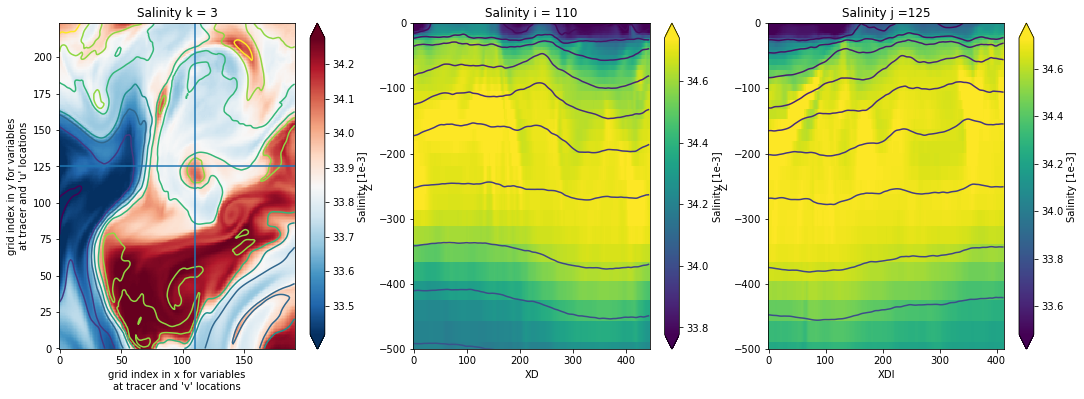

In [184]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

ds.Salt.isel(k=3).plot(robust = True, cmap = 'RdBu_r', ax = ax[0])
ds.density.isel(k=3).plot.contour(robust = True, ax = ax[0])
ds.Salt.isel(i = 110).plot(robust = True, y = 'Z', x = 'XD',ax = ax[1])
ds.density.isel(i=110).plot.contour(robust = True,y='Z',x = 'XD' ,ax = ax[1], levels = 50)
ds.Salt.isel(j = 125).plot(robust = True, y = 'Z', x = 'XDI',ax = ax[2])
ds.density.isel(j=125).plot.contour(robust = True,y = 'Z', x = 'XDI',ax = ax[2], levels = 50)
ax[2].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('Salinity k = 3')
ax[1].set_title('Salinity i = 110')
ax[2].set_title('Salinity j =125')
ax[0].axhline(125)
ax[0].axvline(110)